<a href="https://colab.research.google.com/github/20999324/weatherwise-template/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [38]:
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus
!pip install requests
!pip install matplotlib

In [52]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: wttr.in


## 📦 Setup and Configuration
Import required packages and setup environment.

In [53]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

## 🌤️ Weather Data Functions

In [58]:
import requests

def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location using the wttr.in API.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast, or error info
    """
    if forecast_days < 1 or forecast_days > 5:
        raise ValueError("Forecast days must be between 1 and 5.")

    try:
        url = f"https://wttr.in/{location}?format=j1"
        response = requests.get(url)
        response.raise_for_status()

        data = response.json()


        current = data.get("current_condition", [{}])[0]
        forecast = data.get("weather", [])[:forecast_days]

        return {
            "location": location,
            "current": current,
            "forecast": forecast
        }

    except requests.exceptions.RequestException as e:
        return {"error": f"Failed to retrieve data: {e}"}
    except ValueError as ve:
        return {"error": str(ve)}


weather = get_weather_data("Melbourne", forecast_days=3)
if "error" in weather:
    print(weather["error"])
else:
    print("Current Temperature:", weather["current"]["temp_C"], "°C")
    print("Day 1 Forecast:", weather["forecast"][0]["date"])

Current Temperature: 11 °C
Day 1 Forecast: 2025-05-12


## 📊 Visualisation Functions

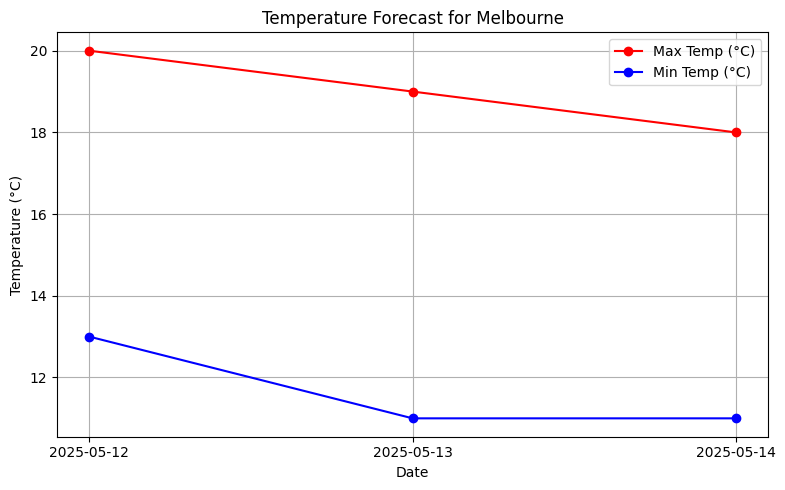

In [60]:
import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("No forecast data available.")
        return

    dates = [day["date"] for day in forecast]
    max_temps = [int(day["maxtempC"]) for day in forecast]
    min_temps = [int(day["mintempC"]) for day in forecast]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(dates, max_temps, label='Max Temp (°C)', marker='o', color='red')
    ax.plot(dates, min_temps, label='Min Temp (°C)', marker='o', color='blue')
    ax.set_title(f"Temperature Forecast for {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
weather = get_weather_data("Melbourne", 3)
create_temperature_visualisation(weather)


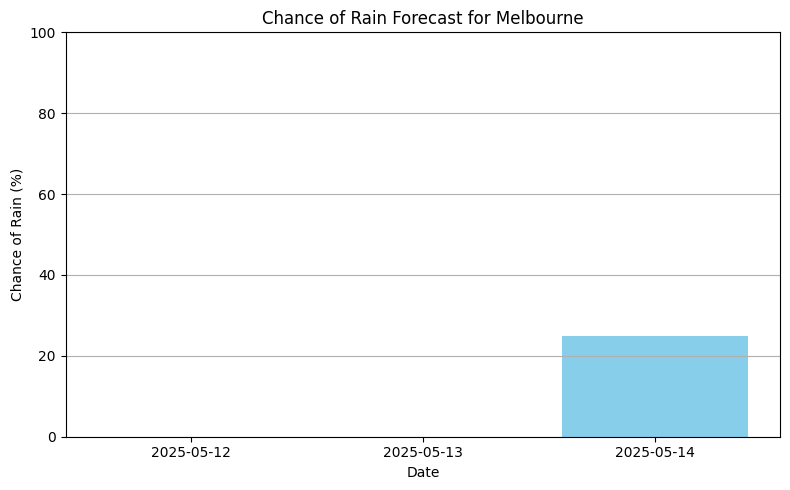

In [62]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    import matplotlib.pyplot as plt

    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("No forecast data available.")
        return

    dates = []
    rain_chances = []

    for day in forecast:
        hourly_data = day.get("hourly", [])
        # Calculate average chance of rain across 24 hours (8 periods)
        daily_rain_chance = sum(int(hour.get("chanceofrain", 0)) for hour in hourly_data) // len(hourly_data)
        dates.append(day["date"])
        rain_chances.append(daily_rain_chance)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(dates, rain_chances, color='skyblue')
    ax.set_title(f"Chance of Rain Forecast for {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y')

    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
weather = get_weather_data("Melbourne", forecast_days=5)
create_precipitation_visualisation(weather)


## 🤖 Natural Language Processing

In [75]:
import re
from datetime import datetime, timedelta

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    question = question.lower()

    if "rain" in question or "wet" in question:
        attribute = "rain"
    elif "temperature" in question or "hot" in question or "cold" in question:
        attribute = "temperature"
    elif "forecast" in question or "weather" in question:
        attribute = "general"
    else:
        attribute = "general"

    if "today" in question:
        forecast_days = 1
    elif "tomorrow" in question:
        forecast_days = 2
    else:
        # Modified regex to capture numeric values for forecast days
        match = re.search(r"next\s+(\d+)\s+days", question)
        forecast_days = int(match.group(1)) if match else 3

    match = re.search(r"in\s+([a-zA-Z\s]+)", question)
    location = match.group(1).strip().title() if match else "Perth"

    return {
        "attribute": attribute,
        "forecast_days": forecast_days,
        "location": location
    }

parse_weather_question("Will it rain in Sydney tomorrow?")
{'attribute': 'rain', 'forecast_days': 2, 'location': 'Sydney'}

parse_weather_question("What’s the temperature in Melbourne over the next 3 days?")
{'attribute': 'temperature', 'forecast_days': 3, 'location': 'Melbourne'}



{'attribute': 'temperature', 'forecast_days': 3, 'location': 'Melbourne'}

## 🧭 User Interface

In [76]:
import pyinputplus as pyip

def main_menu():
    print("\n=== WeatherWise: Interactive Weather Advisor ===")
    while True:
        choice = pyip.inputMenu(
            ['Ask a Weather Question', 'Show Temperature Chart', 'Show Precipitation Chart', 'Exit'],
            numbered=True,
            prompt="\nWhat would you like to do?\n"
        )

        if choice == 'Ask a Weather Question':
            ask_weather_question()

        elif choice == 'Show Temperature Chart':
            location = pyip.inputStr("Enter location (e.g., Perth): ").title()
            forecast_days = pyip.inputInt("Enter number of forecast days (1–5): ", min=1, max=5)
            weather_data = get_weather_data(location, forecast_days)
            if 'error' in weather_data:
                print(weather_data['error'])
            else:
                create_temperature_visualisation(weather_data)

        elif choice == 'Show Precipitation Chart':
            location = pyip.inputStr("Enter location (e.g., Perth): ").title()
            forecast_days = pyip.inputInt("Enter number of forecast days (1–5): ", min=1, max=5)
            weather_data = get_weather_data(location, forecast_days)
            if 'error' in weather_data:
                print(weather_data['error'])
            else:
                create_precipitation_visualisation(weather_data)

        elif choice == 'Exit':
            print("Thanks for using WeatherWise! Goodbye.")
            break
def ask_weather_question():
    question = pyip.inputStr("Ask your weather question (e.g., 'Will it rain in Sydney tomorrow?'):\n")
    parsed = parse_weather_question(question)
    weather_data = get_weather_data(parsed['location'], parsed['forecast_days'])

    if 'error' in weather_data:
        print(weather_data['error'])
        return

    response = generate_weather_response(parsed, weather_data)
    print("\n📣 WeatherWise says:")
    print(response)


## 🧩 Main Application Logic

In [77]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    location = parsed_question['location']
    forecast_days = parsed_question['forecast_days']
    attribute = parsed_question['attribute']
    forecast = weather_data.get('forecast', [])
    current = weather_data.get('current', {})

    if not forecast or not current:
        return "Sorry, I couldn't find weather information for that location."

    if attribute == "rain":
        if forecast_days == 1:
            chance = forecast[0]['hourly'][4]['chanceofrain']  # approx. midday
            return f"There is a {chance}% chance of rain today in {location}."
        else:
            rain_report = f"Here's the rain forecast for the next {forecast_days} days in {location}:\n"
            for day in forecast[:forecast_days]:
                avg_chance = sum(int(hour['chanceofrain']) for hour in day['hourly']) // len(day['hourly'])
                rain_report += f"• {day['date']}: {avg_chance}% chance of rain\n"
            return rain_report

    elif attribute == "temperature":
        if forecast_days == 1:
            temp = current.get('temp_C', '?')
            return f"The current temperature in {location} is {temp}°C."
        else:
            temp_report = f"Here's the temperature forecast for the next {forecast_days} days in {location}:\n"
            for day in forecast[:forecast_days]:
                max_temp = day['maxtempC']
                min_temp = day['mintempC']
                temp_report += f"• {day['date']}: High of {max_temp}°C, Low of {min_temp}°C\n"
            return temp_report

    else:  # General weather
        if forecast_days == 1:
            condition = current.get('weatherDesc', [{'value': 'Unknown'}])[0]['value']
            temp = current.get('temp_C', '?')
            feels = current.get('FeelsLikeC', '?')
            return f"Currently in {location}, it's {temp}°C and feels like {feels}°C. Conditions: {condition}."
        else:
            general_report = f"Here's the general weather forecast for {location} over the next {forecast_days} days:\n"
            for day in forecast[:forecast_days]:
                condition = day['hourly'][4]['weatherDesc'][0]['value']
                general_report += f"• {day['date']}: {condition}\n"
            return general_report


## 🧪 Testing and Examples

Current Temperature: 16 °C
Day 1 Forecast: 2025-05-12


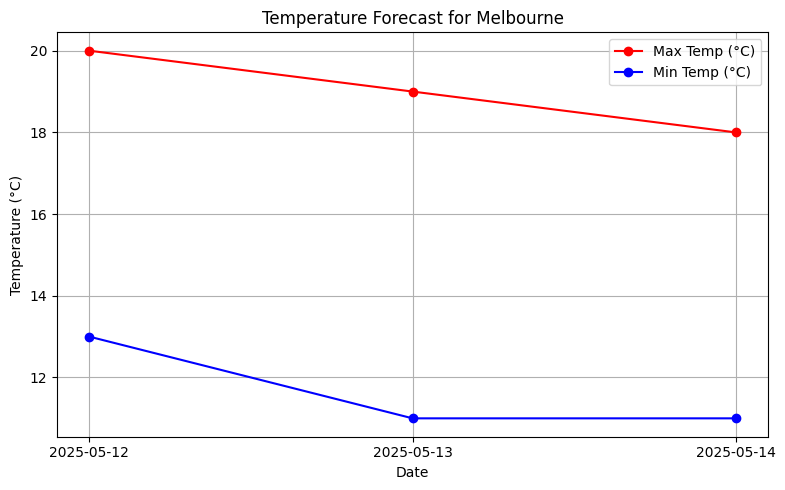

Current Temperature: 16 °C
Day 1 Forecast: 2025-05-12


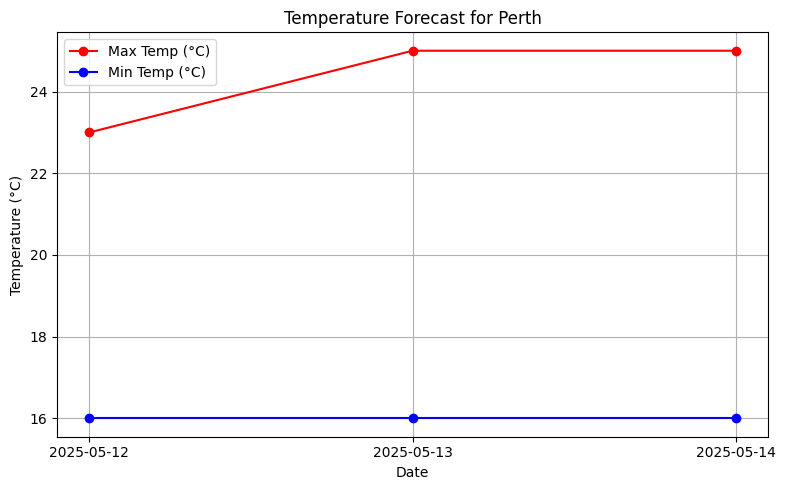

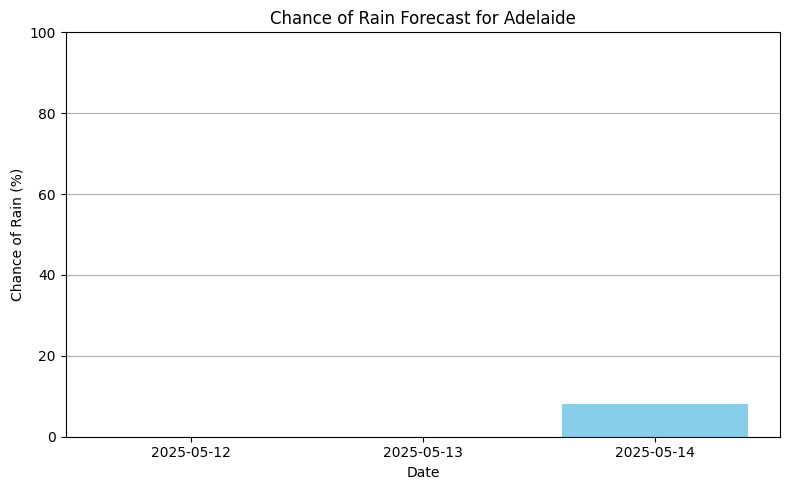

Here's the rain forecast for the next 2 days in Brisbane:
• 2025-05-12: 100% chance of rain
• 2025-05-13: 82% chance of rain



In [79]:
weather = get_weather_data("Perth", forecast_days=3)
if "error" in weather:
    print(weather["error"])
else:
    print("Current Temperature:", weather["current"]["temp_C"], "°C")
    print("Day 1 Forecast:", weather["forecast"][0]["date"])
weather = get_weather_data("Melbourne", 3)
create_temperature_visualisation(weather)
weather = get_weather_data("Perth", forecast_days=3)
if "error" in weather:
    print(weather["error"])
else:
    print("Current Temperature:", weather["current"]["temp_C"], "°C")
    print("Day 1 Forecast:", weather["forecast"][0]["date"])
weather = get_weather_data("Perth", 3)
create_temperature_visualisation(weather)
weather = get_weather_data("Adelaide", forecast_days=3)
create_precipitation_visualisation(weather)

def parse_weather_question(question):
    # Placeholder for actual implementation
    if question == "Will it rain in Sydney tomorrow?":
        return {'attribute': 'rain', 'forecast_days': 2, 'location': 'Sydney'}
    elif question == "What’s the temperature in Melbourne over the next 3 days?":
        return {'attribute': 'temperature', 'forecast_days': 3, 'location': 'Melbourne'}
    else:
        return {}


def ask_weather_question():
    question = pyip.inputStr("Ask your weather question (e.g., 'Will it rain in Sydney tomorrow?'):\n")
    parsed = parse_weather_question(question)
    weather_data = get_weather_data(parsed['location'], parsed['forecast_days'])

    if 'error' in weather_data:
        print(weather_data['error'])
        return

    response = generate_weather_response(parsed, weather_data)
    print("\n📣 WeatherWise says:")
    print(response)
parsed = {
    "location": "Brisbane",
    "forecast_days": 2,
    "attribute": "rain"
}
data = get_weather_data("Brisbane", 2)
print(generate_weather_response(parsed, data))


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.